In [ ]:
conda env export > environment.yml

In [105]:
import os
import re, string, unicodedata
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

In [106]:
import inflect
from spellchecker import SpellChecker
import csv

In [107]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords

In [108]:
# import dataset
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

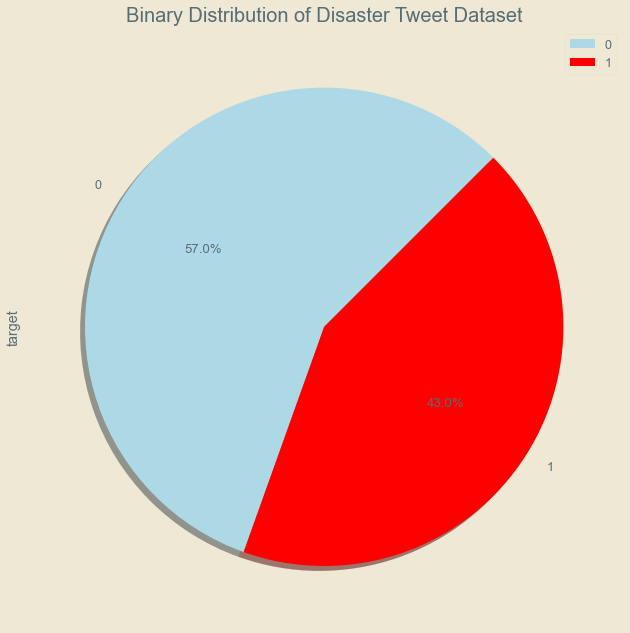

In [109]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

In [110]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}

In [111]:
location_expansion_dict = csv2dict('location_expansion.csv')
word_expansion_dict = csv2dict('word_expansions.csv')



    def proper_nouns_lower(text): 
        text = re.sub('#', ' ', text)
        proper_noun = re.match(r"(?<=[A-Z])[a-z]", text)
        if text is proper_noun:
            new_string = re.sub(proper_noun, proper_noun.group(0).lower(), text)
        else:
            new_string = text
        return new_string
        
        
    def word_expansion(text):
        c_re = re.compile('|'.join('(\b%s\b)' % re.escape(s) for s in word_expansion_dict.keys()), re.IGNORECASE)
        def replace(match):
            expansion =  f" {word_expansion_dict[match.group(0)]}"
            return expansion
        text = c_re.sub(replace, text.lower())
        return text


In [112]:
def expand_hashtags(text):
    hashtag_list = []
    hashtag_exp_list = []

    def camel_case_split(text):
        text = re.sub('#', ' ', text)
        # regex to insert space before uppercase letter when not at start of line using pos.lookahead and pos.lookbehind
        exp_hashtags = re.sub(r'((?<!\A)(?<=[a-z])[A-Z]|(?<!\A)(?=[A-Z])[a-z+])', r' \1', text)
        return exp_hashtags
        
    def denoise_hashtag_text(text):
        new_text = re.sub(r"\S*https?:\S*",  r"", text)
        new_text_punct = re.sub(r"[^\w\s#]",  r"", new_text)
        new_text_chars = re.sub('[^\u0000-\u007f]', '',  new_text_punct)
        new_text_ = re.sub('_', '',  new_text_chars)
        return new_text_
    
    def replace_numbers(tokens):
        dig2word = inflect.engine()
        new_tokens = []
        for word in tokens:
            if word.isdigit():
                new_word = dig2word.number_to_words(word)
                new_tokens.append(new_word)
            else:
                new_tokens.append(word)
        return new_tokens
    
    for tweet in text:
        for x in tweet.split():
            if x.startswith('#') == True:
                clean_text = denoise_hashtag_text(x)
                cleaner_text = replace_numbers(clean_text)
                hashtag_list.append(''.join(cleaner_text))
                
    for hashtag in hashtag_list: 
        exp_hashtag = camel_case_split(hashtag)
        strip_hash = exp_hashtag.strip()
        hashtag_exp_list.append(strip_hash)
        
    return dict(zip(hashtag_list, hashtag_exp_list))

In [113]:
loc_hashtags_dict = expand_hashtags(df.location.astype(str))
hashtags_dict = expand_hashtags(df.text)

In [114]:
test_loc_hashtags_dict = expand_hashtags(test_df.location.astype(str))
test_hashtags_dict = expand_hashtags(test_df.text)

In [115]:
def expand_words(df, hashtag_dict, expansion_dict):
    
    def camel_sub(text):
        cam_re = re.compile(r'(\b%s\b)' % '|'.join(hashtag_dict.keys()))
        def replace(match):
            expansion =  f" {hashtag_dict[match.group(0)]}"
            return expansion
        text = cam_re.sub(replace, text)
        return text
    
    def word_expansion(text):
        c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
        def replace(match):
            expansion =  f"{expansion_dict[match.group(0)]}"
            return expansion
        text = c_re.sub(replace, text.lower())
        return text
    
    text = camel_sub(df)
    expanded_text = word_expansion(text)
    return expanded_text

In [116]:
def remove_non_ascii(tokens):
        new_tokens = []
        for word in tokens:
            new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_tokens.append(new_token)
        return new_tokens

In [146]:
#### text preprocessing specifically formatted for tweets but will work on any text
def tweet_preprocess(df): 
    """combine regex and nltk processing for tweet text processing"""

    def denoise_tweet(text):
        new_text = re.sub(r"\S*https?:\S*",  r"", text)
        x = re.sub('#cafire', 'california fire', new_text)
        x = re.sub('#calfires', 'california fires', x)
        x = re.sub('#calwildfires', 'california wildfires', x)
        x = re.sub('#cadrought', 'california drought', x)
        x = re.sub('nan', '', x)
        nan_text = re.sub('nan', '', x)
        new_text_punct = re.sub(r"[^\w\s@]",  r" ", nan_text)
        text_digit = re.sub(r"\d",  r" ", new_text_punct)
        km_text = re.sub('km', 'kilometers', text_digit)
        unicode_chars = re.sub('[^\u0000-\u007f]', ' ', km_text)
        return unicode_chars.strip()
    
# tokenization & lemmatization function returns tokens    
    def lemmatize_text(text):
        tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        lemmatizer = WordNetLemmatizer() 
        return [lemmatizer.lemmatize(w, pos='v') for w in tokenizer.tokenize(text)]

    def replace_numbers(tokens):
        dig2word = inflect.engine()
        new_tokens = []
        for word in tokens:
            if word.isdigit():
                new_word = dig2word.number_to_words(word)
                new_tokens.append(new_word)
            else:
                new_tokens.append(word)
        return new_tokens
    
    def remove_non_ascii(tokens):
        new_tokens = []
        for word in tokens:
            new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_tokens.append(new_token)
        return new_tokens
      
    def remove_stopwords(tokens):
        stop_list = stopwords.words('english')  
        new_tokens = []
        for word in tokens:
            if word not in stop_list:
                new_tokens.append(word)
        return new_tokens
    
    def norm_text(tokens):
        words = replace_numbers(tokens)
        tokens = remove_stopwords(words)
        words = remove_non_ascii(tokens)
        return words
    
    def process_text(text):
        exp_text = expand_words(text, hashtags_dict, word_expansion_dict)
        clean_text = denoise_tweet(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join([x for x in norm_text(lem_text)])
        text = re.sub(r"-",  r" ", text)
        text = re.sub(r'nan',  r"", text)
        return text
    
    new_df = [process_text(x) for x in df]

    return new_df 

In [147]:
df['tweets'] = tweet_preprocess(df.text)
df['keyword'] = tweet_preprocess(df.keyword.astype(str).replace({r"%20" : r" "}, regex=True))

In [148]:
test_df['tweets'] = tweet_preprocess(test_df.text)
test_df['keyword'] = tweet_preprocess(test_df.keyword.astype(str).replace({r"%20" : r" "}, regex=True))

In [149]:
def preprocess_location(df):

    def lemmatize_loc_text(text):
        tokenizer = TweetTokenizer(strip_handles=True)
        lemmatizer = WordNetLemmatizer() 
        return [lemmatizer.lemmatize(w, pos='n') for w in tokenizer.tokenize(text)]
    
    def norm_loc_text(tokens):
        words = remove_non_ascii(tokens)
        return words
    
    def denoise_location_text(text):
        text = str(text)
        exp_text = expand_words(text, loc_hashtags_dict, location_expansion_dict)
        non_url_str = re.sub(r"\S*https?:\S*",  r"", exp_text.lower())
        alpha_str = re.sub(r"[^a-zA-Z]",  r" ", non_url_str)
        clean_text = re.sub(r'nan',  r"", alpha_str)
        unicode_string = re.sub('[^\u0000-\u007f]', '',  clean_text)
        lem_text = lemmatize_loc_text(unicode_string)
        new_text = ' '.join([x for x in norm_loc_text(lem_text)])
        new_text = re.sub(r"est",  r"", new_text)
        return new_text

    
    new_df = [denoise_location_text(x) for x in df]
    return new_df 



In [150]:
df['clean_location'] = preprocess_location(df.location)

In [151]:
test_df['clean_location'] = preprocess_location(test_df.location)

In [154]:
def combine_columns(df):
    df['keyword'] = df.keyword.astype(str)
    df['keyword'] = df.keyword.str.lower()
    df['keyword'] = df.keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweets.apply(lambda row: row.split())
    return df

In [159]:
test_df.drop(['id', 'location', 'text'], axis=1, inplace=True)
df.drop(['id', 'location', 'text'], axis=1, inplace=True)

In [161]:
train_df = combine_columns(df)
test_df = combine_columns(test_df)

In [163]:
test_df.to_csv('test_update.csv')
train_df.to_csv('train_update.csv')

In [5]:
df = pd.read_csv('train_update.csv')
test_df = pd.read_csv('test_update.csv')

In [45]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

In [46]:
corpus = train_df.tweets
new_spelling=[]
sym_spell = SymSpell(max_dictionary_edit_distance=1)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
for term in corpus:
    if len(term)>1:
        result = sym_spell.word_segmentation(term)
        r = result.corrected_string
    else:
        r = ''
    new_spelling.append(r)

In [95]:
from wordsegmentation import WordSegment

In [96]:
from wordsegmentation import WordSegment
ws = WordSegment()

ws.segment('universityofwashington')

In [48]:
twt = list(train_df.tweets)
twt

['deeds reason earthquake may allah forgive us',
 'forest fire near la ronge sask canada',
 'residents ask shelter place notify officer evacuation shelter place order expect',
 'people receive wildfires evacuation order california',
 'get send photo ruby alaska smoke wildfires pour school',
 'rocky fire update california highway close directions due lake county fire cafire wildfires',
 'flood disaster heavy rain cause flash flood streets manitou colorado spring areas',
 'top hill see fire woods',
 'emergency evacuation happen build across street',
 'afraid tornado come area',
 'three people die heat wave far',
 'haha south tampa get flood hah wait second live south tampa gonna gonna fuck flood',
 'rain flood florida tampa bay tampa days lose count',
 'flood bago myanmar arrive bago',
 'damage school bus multi car crash break',
 'man',
 'love fruit',
 'summer lovely',
 'car fast',
 'goooaaal',
 'ridiculous',
 'london cool',
 'love ski',
 'wonderful day',
 'loool',
 'way eat shit',
 'nyc

In [92]:
print(len(new_spelling))

7613


In [56]:
df.combined_tokens

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, ask, shelter, place, notify, offic...
3       [people, receive, wildfires, evacuation, order...
4       [get, send, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridge, collapse, ne...
7609    [control, wild, fire, california, even, northe...
7610                   [utc, kilometers, volcano, hawaii]
7611    [police, investigate, e, bike, collide, car, l...
7612    [latest, home, raze, northern, california, wil...
Name: combined_tokens, Length: 7613, dtype: object

In [57]:
from spellchecker import SpellChecker
og_wrd = []
new_wrd = []
other_wrd = []
spell = SpellChecker()
tokes = list(train_df.combined_tokens.astype(str))

# find those words that may be misspelled
misspelled = list(spell.unknown(tokes))
print(missp)
for word in misspelled:
    og_wrd.append(word)
    # Get the one `most likely` answer
    new_wrd.append(spell.correction(word))

    # Get a list of `likely` options
    other_wrd.append(spell.candidates(word))

In [66]:
misspelled

["['like', 'pasta']",
 "['devastate', 'cher', 'devastate']",
 "['dead', 'dead']",
 "['alrighty', 'hit', 'blaze', 'blaze']",
 "['puncture', 'wound', 'wound']",
 "['scream', 'griffin', 'scream']",
 "['crush', 'holy', 'shit', 'crush']",
 "['survive', 'everywhere', 'survive']",
 "['big', 'love', 'london', 'siren']",
 "['stats', 'blizzard']",
 "['crash', 'kenton', 'ohio', 'crash']",
 "['wonderful', 'day']",
 "['thirst', 'curfew', 'curfew']",
 "['fatality', 'honduras', 'fatality']",
 "['drown', 'ct', 'ny', 'drown']",
 "['change', 'weapon', 'weapon']",
 "['traumatise', 'traumatise']",
 "['oh', 'god', 'earthquake']",
 "['drop', 'nigga', 'damage', 'damage']",
 "['love', 'girlfriend']",
 "['good', 'stay', 'ny', 'hellfire']",
 "['curfew', 'curfew']",
 "['go', 'starve', 'death', 'death']",
 "['wha', 'kid', 'damage', 'damage']",
 "['stop', 'stretcher']",
 "['love', 'ski']",
 "['show', 'picture', 'stretcher']",
 "['nyc', 'last', 'week']",
 "['crush', 'crush']",
 "['weapon', 'scar', 'karma', 'weapon'

In [87]:
from spellchecker import SpellChecker
misspelled_list = []
misspelled_suggestions = []
ms_others = []
spell = SpellChecker()

misspelled = spell.unknown(tokes)
    

for word in misspelled:
    misspelled_list.append(word)
    misspelled_suggestions.append(spell.correction(word))
    ms_others.append(spell.candidates(word))

In [90]:
tokes

["['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']",
 "['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']",
 "['residents', 'ask', 'shelter', 'place', 'notify', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expect']",
 "['people', 'receive', 'wildfires', 'evacuation', 'order', 'california']",
 "['get', 'send', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pour', 'school']",
 "['rocky', 'fire', 'update', 'california', 'highway', 'close', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires']",
 "['flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flood', 'streets', 'manitou', 'colorado', 'spring', 'areas']",
 "['top', 'hill', 'see', 'fire', 'woods']",
 "['emergency', 'evacuation', 'happen', 'build', 'across', 'street']",
 "['afraid', 'tornado', 'come', 'area']",
 "['three', 'people', 'die', 'heat', 'wave', 'far']",
 "['haha', 'south', 'tampa', 'get', 'flood', 'hah', 'wait', 'second', 'live', 'south', 'tampa', 'gonna', 'gonna',

In [89]:
misspelled_suggestions

["['like', 'pasta']",
 "['devastate', 'cher', 'devastate']",
 "['dead', 'dead']",
 "['alrighty', 'hit', 'blaze', 'blaze']",
 "['puncture', 'wound', 'wound']",
 "['scream', 'griffin', 'scream']",
 "['crush', 'holy', 'shit', 'crush']",
 "['survive', 'everywhere', 'survive']",
 "['big', 'love', 'london', 'siren']",
 "['stats', 'blizzard']",
 "['crash', 'kenton', 'ohio', 'crash']",
 "['wonderful', 'day']",
 "['thirst', 'curfew', 'curfew']",
 "['fatality', 'honduras', 'fatality']",
 "['drown', 'ct', 'ny', 'drown']",
 "['change', 'weapon', 'weapon']",
 "['traumatise', 'traumatise']",
 "['oh', 'god', 'earthquake']",
 "['drop', 'nigga', 'damage', 'damage']",
 "['love', 'girlfriend']",
 "['good', 'stay', 'ny', 'hellfire']",
 "['curfew', 'curfew']",
 "['go', 'starve', 'death', 'death']",
 "['wha', 'kid', 'damage', 'damage']",
 "['stop', 'stretcher']",
 "['love', 'ski']",
 "['show', 'picture', 'stretcher']",
 "['nyc', 'last', 'week']",
 "['crush', 'crush']",
 "['weapon', 'scar', 'karma', 'weapon'

In [81]:
suggestion_list=[]
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=3)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
for input_term in tokes:
# max edit distance per lookup (per single word, not per whole input string)
    suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
    for suggestion in suggestions:
        suggestion_list.append(suggestion)
        print(suggestion)

In [84]:
print(len(suggestion_list))

7613


In [101]:
train_df

,keyword,target,tweets,clean_location,all_text,tokens,combined_tokens,tweet_tokens
0,,1,deeds reason earthquake may allah forgive us,,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv..."
1,,1,forest fire near la ronge sask canada,,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,,1,residents ask shelter place notify officer eva...,,residents ask shelter place notify officer eva...,"[residents, ask, shelter, place, notify, offic...","[residents, ask, shelter, place, notify, offic...","[residents, ask, shelter, place, notify, offic..."
3,,1,people receive wildfires evacuation order cali...,,people receive wildfires evacuation order cali...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,,1,get send photo ruby alaska smoke wildfires pou...,,get send photo ruby alaska smoke wildfires pou...,"[get, send, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...,...,...,...
7608,,1,two giant crane hold bridge collapse nearby home,,two giant crane hold bridge collapse nearby home,"[two, giant, crane, hold, bridge, collapse, ne...","[two, giant, crane, hold, bridge, collapse, ne...","[two, giant, crane, hold, bridge, collapse, ne..."
7609,,1,control wild fire california even northern par...,,control wild fire california even northern par...,"[control, wild, fire, california, even, northe...","[control, wild, fire, california, even, northe...","[control, wild, fire, california, even, northe..."
7610,,1,utc kilometers volcano hawaii,,utc kilometers volcano hawaii,"[utc, kilometers, volcano, hawaii]","[utc, kilometers, volcano, hawaii]","[utc, kilometers, volcano, hawaii]"
7611,,1,police investigate e bike collide car little p...,,police investigate e bike collide car little p...,"[police, investigate, e, bike, collide, car, l...","[police, investigate, e, bike, collide, car, l...","[police, investigate, e, bike, collide, car, l..."


In [103]:
# Creating the dicti
word_dict = {} 


for tweet in train_df.tweets: 
    words = tweet.split()
    
    for word in words:
        if word not in word_dict.keys(): 
            word_dict[word] = 1
        else: 
            word_dict[word] += 1
print(len(word_dict))
max(word_dict, key=word_dict.get)

11958


'get'

In [104]:
word_dict

{'deeds': 2,
 'reason': 31,
 'earthquake': 50,
 'may': 88,
 'allah': 9,
 'forgive': 6,
 'us': 158,
 'forest': 66,
 'fire': 367,
 'near': 58,
 'la': 23,
 'ronge': 1,
 'sask': 1,
 'canada': 13,
 'residents': 8,
 'ask': 30,
 'shelter': 7,
 'place': 35,
 'notify': 1,
 'officer': 38,
 'evacuation': 50,
 'order': 41,
 'expect': 33,
 'people': 217,
 'receive': 4,
 'wildfires': 10,
 'california': 121,
 'get': 433,
 'send': 52,
 'photo': 42,
 'ruby': 1,
 'alaska': 7,
 'smoke': 54,
 'pour': 4,
 'school': 70,
 'rocky': 15,
 'update': 56,
 'highway': 19,
 'close': 39,
 'directions': 1,
 'due': 31,
 'lake': 14,
 'county': 38,
 'cafire': 2,
 'flood': 169,
 'disaster': 158,
 'heavy': 21,
 'rain': 60,
 'cause': 58,
 'flash': 21,
 'streets': 8,
 'manitou': 1,
 'colorado': 16,
 'spring': 18,
 'areas': 10,
 'top': 58,
 'hill': 12,
 'see': 150,
 'woods': 2,
 'emergency': 158,
 'happen': 56,
 'build': 159,
 'across': 20,
 'street': 24,
 'afraid': 5,
 'tornado': 33,
 'come': 161,
 'area': 50,
 'three': 31,


In [945]:
train_df

,Unnamed: 0,keyword,target,tweets,clean_location,all_text
0,0,NaN,1,deeds reason earthquake may allah forgive us,NaN,
1,1,NaN,1,forest fire near la ronge sask canada,NaN,
2,2,NaN,1,residents ask shelter place notify officer eva...,NaN,
3,3,NaN,1,thirteen thousand people receive wildfires eva...,NaN,
4,4,NaN,1,get send photo ruby alaska smoke wildfires pou...,NaN,
...,...,...,...,...,...,...
7608,7608,NaN,1,two giant crane hold bridge collapse nearby home,NaN,
7609,7609,NaN,1,control wild fire california even northern par...,NaN,
7610,7610,NaN,1,m194 one hundred and four utc 5km volcano hawaii,NaN,
7611,7611,NaN,1,police investigate ebike collide car little po...,NaN,
